In [207]:
%matplotlib inline
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

from matplotlib.lines import Line2D

In [2]:
from importlib import reload

from wombats import utils
from wombats import metrics
from wombats import models
from wombats import perturbations
import random
# if changes to the files run this to reload the moduls
utils = reload(utils)
metrics = reload(metrics)
models = reload(models)

In [3]:
data_file = Path('../data/steinmetz/steinmetz_all.npy')
data_folder = Path('../data/steinmetz/')
if not data_file.exists():
    data = utils.load_steinmentz()
    data_folder.mkdir(parents=True)
    data_file.touch()
    np.save(data_file, data)
else:
    data = np.load(data_file, allow_pickle=True)

In [4]:
def train_models(session_data, trials):
    stim, region1_data, region2_data, response = get_trial_data(session_data, trials)

    # train the model
    A1 = models.get_a1(stim, region1_data)
    A2 = models.get_a2(stim@A1, region2_data)  ## input is encoder output
    A3 = models.get_a3(region2_data, response)
    
    A = np.array([A1, A2, A3], dtype=object)
    return A


def get_fit_r2(in_data, fit_matrix, out_data):
    out_data_hat = (in_data@fit_matrix).T
    
    with np.errstate(divide='ignore', invalid='ignore'):
        r2 = metrics.r2(np.squeeze(out_data), out_data_hat)
        
    r2[~np.isfinite(r2)] = np.nan
    return np.nanmean(r2)

def get_trial_data(session_data, trials):
    stim = session_data['stim'][trials]
    region1_data = session_data['fr']['region1'][:, trials]
    region2_data = session_data['fr']['region2'][:, trials]
    response = session_data['response'][trials]
    response[response==0]=np.nan
    response[response>0]=1
    response[response<0]=0
    
    return stim, region1_data, region2_data, response    


def get_fit_performance_by_mat(session_data, A, trials):
    stim, region1_data, region2_data, response = get_trial_data(session_data, trials)
 
    R2 = np.zeros(3)
    R2[0] = get_fit_r2(stim, A[0], region1_data)
    R2[1] = get_fit_r2(stim@A[0], A[1], region2_data)
    
    decoder_out = np.squeeze(region2_data).T@A[2]
    R2[2] = metrics.binarry_acc(decoder_out>0, response)
    
    return R2


def add_cross_val_entry_fits(table, start_idx, fold_num, split, scores):
    
    idx = start_idx

    table.loc[idx:(idx+2), 'cross_val_fold'] = fold_num
    table.loc[idx:(idx+2), 'data_split'] = split
    for num in range(3):
        table.loc[idx, 'matrix'] = matrices[num]
        table.loc[idx, 'score'] = scores[num]
        idx+=1
    
    return table, idx
    
def get_full_model_perfomance(session_data, AE, trials):
    stim, region1_data, region2_data, subject_response = get_trial_data(session_data, trials)
    model_response = models.get_model_output(stim, AE=AE)
    
    correct_response = stim_2_labels(stim)
    
    out = np.zeros(3)
    out[0] = metrics.binarry_acc(correct_response, subject_response) # 'TvS'
    out[1] = metrics.binarry_acc(correct_response, model_response) # TvM
    out[2] = metrics.binarry_acc(subject_response, model_response) # SvM
    
    return out

def add_cross_val_entry_model_perf(table, start_idx, fold_num, pert_type, pert_pct, pert_matrix, split, scores):
    
    idx = start_idx
    
    table.loc[idx:(idx+2), 'cross_val_fold'] = fold_num
    table.loc[idx:(idx+2), 'data_split'] = split

    table.loc[idx:(idx+2), 'pert_type'] = pert_type
    table.loc[idx:(idx+2), 'pert_pct'] = pert_pct
    table.loc[idx:(idx+2), 'pert_matrix'] = pert_matrix
    
    for num in range(3):
        table.loc[idx, 'comparison'] = comparisons[num]
        table.loc[idx, 'score'] = scores[num]
        idx+=1
    
    return table, idx

def get_trial_types_idx(trials, trial_type):
    return np.where(trials==trial_type)[0]

def stim_2_labels(stims):
    stim_diff = np.diff(stims[:,1:],1).squeeze()
    stim_diff[stim_diff==0] = np.nan
    stim_diff[stim_diff>0] = 1
    stim_diff[stim_diff<0] = 0

    return stim_diff

In [101]:
utils = reload(utils)

# simulation parameters
time_windows = {0:[-0.5,-0], 1: [0, 0.5], 2: [0.5, 1], 3:[1, 2]}
num_folds = 5
region1_list = ['visual']
region2_list = ['motor']
fit_data_splits = ['train', 'test']

data_split_types = ['train', 'test', 'nono', 'nogo', 'noresp']
comparisons = ['TvS', 'TvM', 'SvM']
pert_types = ['ablation']
pert_pcts = [0, 0.25, 0.5, 0.75]
matrices = ['A1', 'A2', 'A3' ]

# output matrix
perf_df_all = pd.DataFrame(columns=['region1', 'region2', 'session_num', 'time_bin', 'cross_val_fold', 'data_split', 'comparison', 'pert_type', 'pert_pct', 'pert_matrix', 'score'])

fit_perf_df_all = pd.DataFrame(columns=['region1', 'region2', 'session_num', 'time_bin', 'cross_val_fold', 'data_split', 'matrix', 'score'])

# specific data selection, this can be a for loop
region1_num = 0
region2_num = 0

region1 = region1_list[0]
region2 = region2_list[0]


In [102]:
%%time 

perturbations = reload(perturbations)
utils = reload(utils)
metrics = reload(metrics)
models = reload(models)

for time_bin in time_windows.keys():

    # data
    dataset = utils.DataSet(data, region1=region1, region2=region2, analysis_time_window=time_windows[time_bin])

    # pre-allocate outputs
    n_sessions = dataset.n_valid_sessions
    
    
    n_rows = n_sessions * num_folds * len(data_split_types) * len(comparisons) * len(pert_types) * len(pert_pcts) * len(matrices)
    perf_df = pd.DataFrame(index=range(n_rows), columns=['region1', 'region2', 'session_num', 
                                                         'time_bin', 'cross_val_fold', 'data_split', 
                                                         'comparison', 'pert_type', 'pert_pct', 'pert_matrix', 'score'])

    n_core_perf_rows = num_folds * len(data_split_types) * len(matrices)*len(pert_pcts)*len(pert_types)*len(comparisons)
    perf_df['session_num'] = np.repeat(np.arange(n_sessions), n_core_perf_rows)
    perf_df['region1'] = region1
    perf_df['region2'] = region2
    perf_df['time_bin'] = time_bin


    n_rows = n_sessions * num_folds * len(fit_data_splits) * len(matrices)
    fit_perf_df = pd.DataFrame(index=range(n_rows), columns=['region1', 'region2', 'session_num', 
                                                             'time_bin', 'cross_val_fold', 'data_split', 'matrix', 'score'])

    n_core_fit_rows = num_folds * len(fit_data_splits) * len(matrices)
    fit_perf_df['session_num'] = np.repeat(np.arange(n_sessions), n_core_fit_rows)
    fit_perf_df['region1'] = region1
    fit_perf_df['region2'] = region2
    fit_perf_df['time_bin'] = time_bin


    for session_num in range(n_sessions):

        # initiate fit table for session
        session_fit_columns = ['cross_val_fold', 'data_split', 'matrix', 'score']
        n_rows = num_folds * len(fit_data_splits) * len(matrices)
        fit_perf_df_session = pd.DataFrame(index=range(n_rows), columns=session_fit_columns)
        fit_row_counter = 0


        # initiate model_perf table for session
        session_perf_columns = ['cross_val_fold', 'data_split','comparison', 'pert_matrix', 'pert_type', 'pert_pct', 'score']
        n_rows = num_folds * len(data_split_types) * len(matrices)*len(pert_pcts)*len(pert_types)*len(comparisons)
        perf_df_session = pd.DataFrame(index=range(n_rows), columns=session_perf_columns)
        perf_row_counter = 0

        session_data = dataset.data[session_num]

        trials = {}
        for trial_type in ['nogo', 'noresp', 'nono']:
            trials[trial_type] = get_trial_types_idx(session_data['trial_types'], trial_type)


        # get folds splis for valid trials
        cross_val_trials =  get_trial_types_idx(session_data['trial_types'], 'valid')
        stim, _, _, _ = get_trial_data(session_data, cross_val_trials)
        stim_label = stim_2_labels(stim)


        kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=session_num)
        fold_num =0
        for train_index, test_index in kf.split(cross_val_trials, stim_label):

            trials['train'] = cross_val_trials[train_index] 
            trials['test'] = cross_val_trials[test_index]

            A = train_models(session_data, trials['train'])

            for split in ['train', 'test']:
                split_perf = get_fit_performance_by_mat(session_data, A, trials[split])
                fit_perf_df_session, fit_row_counter = add_cross_val_entry_fits(table=fit_perf_df_session,
                                                                                start_idx=fit_row_counter,
                                                                                fold_num=fold_num,
                                                                                split=split,
                                                                                scores=split_perf)    
            for pert_type in pert_types:
                for idx, pert_matrix in enumerate(matrices):
                    for pert_pct in pert_pcts:
                        A_p = np.copy(A)
                        if pert_pct!=0:
                            A_p[idx], _ = perturbations.pert_connections(connection_mat = A[idx], 
                                                                         pert_pct=pert_pct,
                                                                         pert_type=pert_type)
                        AE_p = models.get_ae(A_p)
                        for split in ['train', 'test', 'nogo', 'noresp', 'nono']:
                            split_perf = get_full_model_perfomance(session_data, AE_p, trials[split])

                            perf_df_session, perf_row_counter = add_cross_val_entry_model_perf(table=perf_df_session,
                                                                                              start_idx=perf_row_counter,
                                                                                              fold_num=fold_num,
                                                                                              pert_type=pert_type,
                                                                                              pert_pct=pert_pct,
                                                                                              pert_matrix=pert_matrix,
                                                                                              split=split,
                                                                                              scores=split_perf)


            fold_num+=1

        perf_df.loc[perf_df.session_num==session_num, session_perf_columns] = perf_df_session.values
        fit_perf_df.loc[fit_perf_df.session_num==session_num, session_fit_columns] = fit_perf_df_session.values

    
    perf_df_all = pd.concat((perf_df_all, perf_df))
    fit_perf_df_all = pd.concat((fit_perf_df_all, fit_perf_df))
    

perf_df_all=perf_df_all.astype({'score': 'float'})
perf_df_all=perf_df_all.astype({'pert_pct': 'float'})    

CPU times: user 3min 58s, sys: 4.3 s, total: 4min 3s
Wall time: 25.6 s


In [221]:
perf_df.shape[0]/5*4, 

(10080.0,)

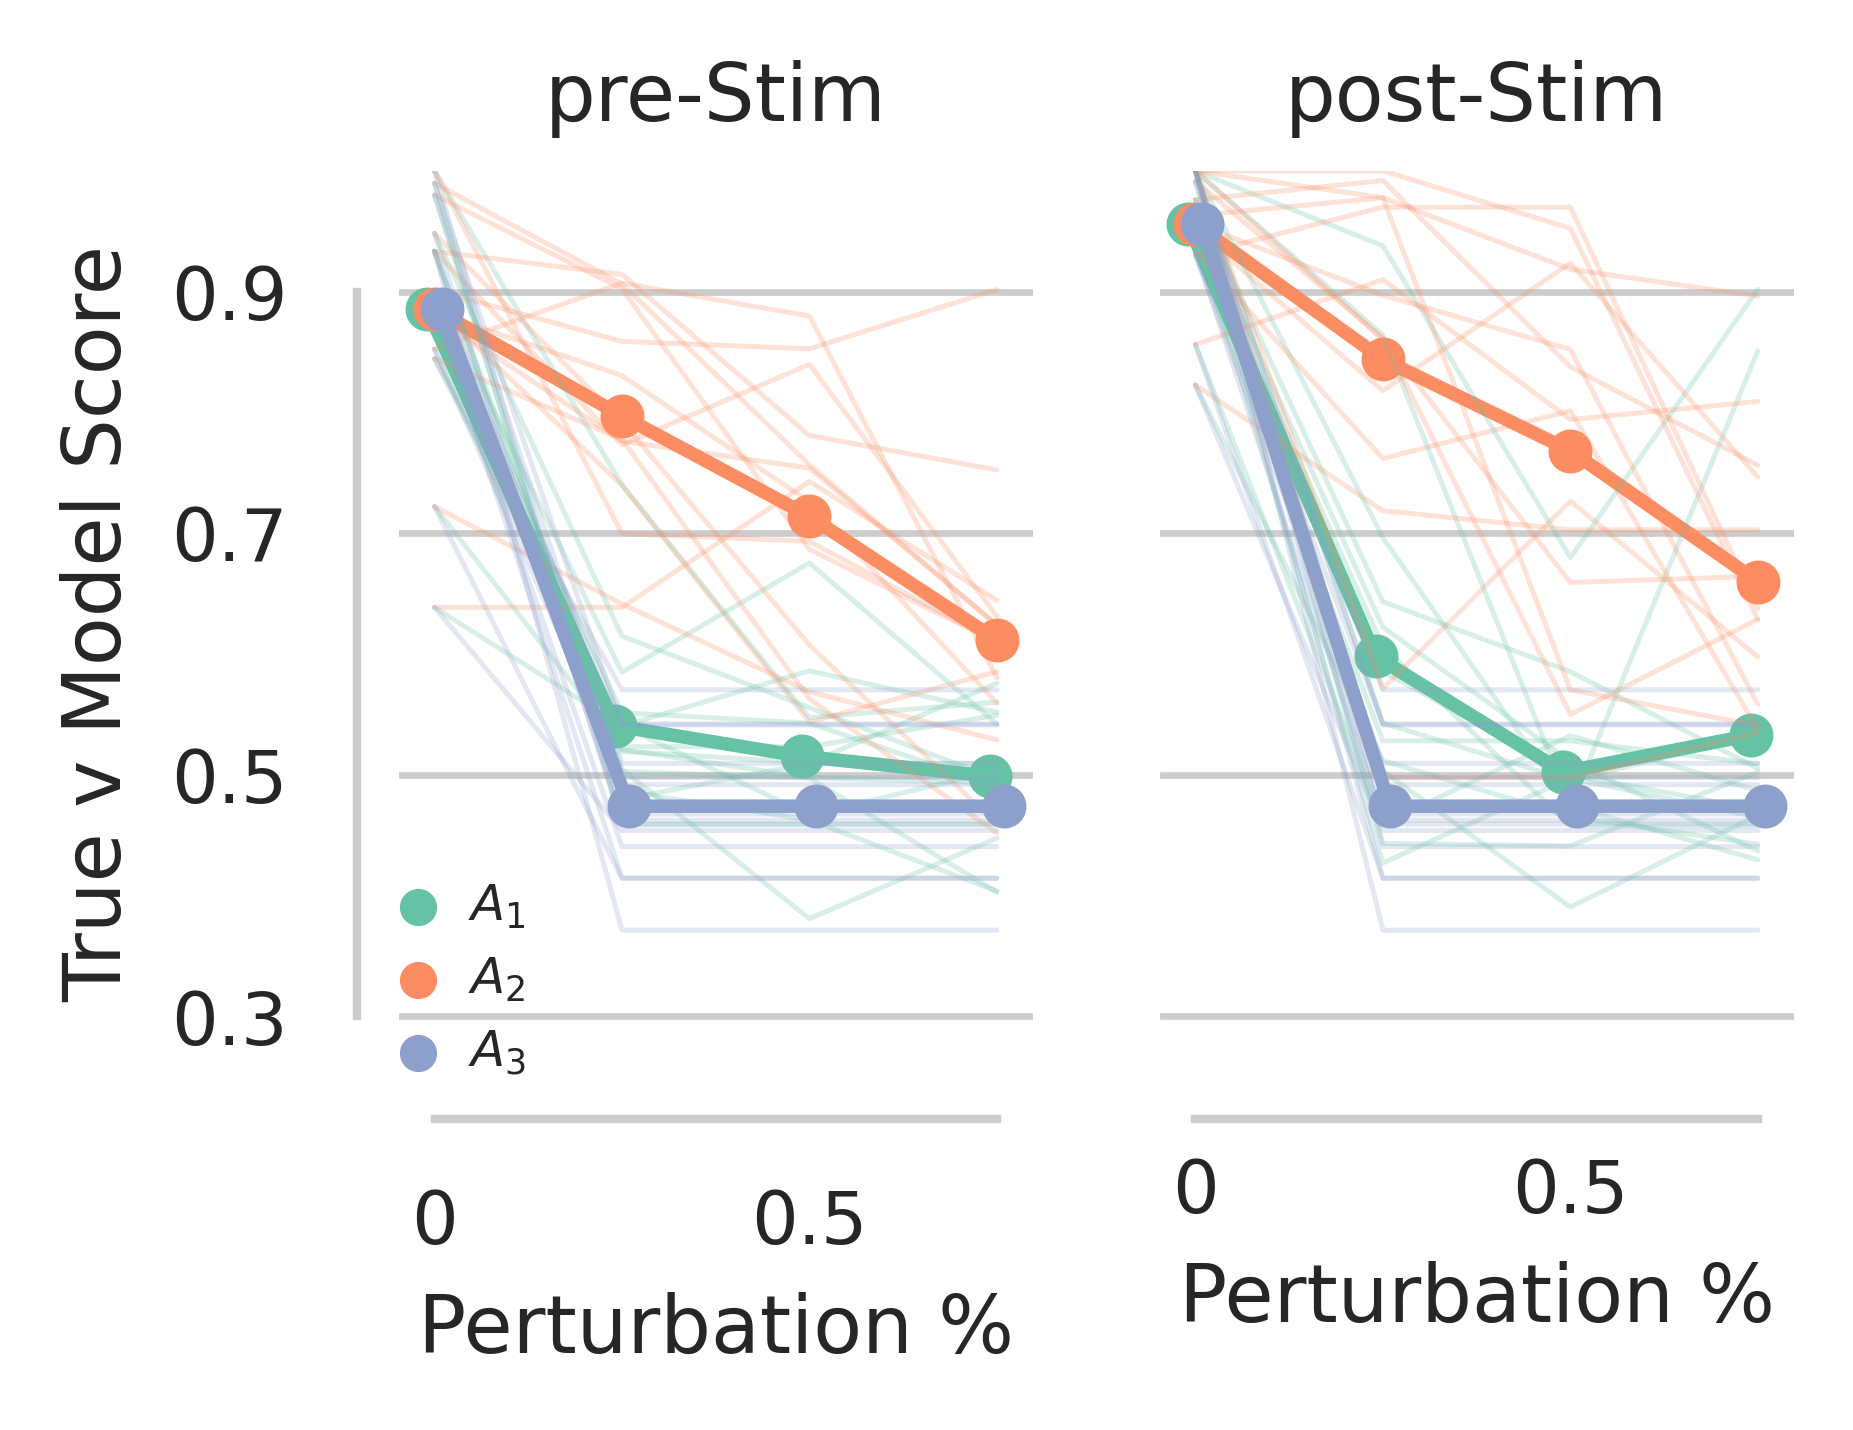

In [217]:


sns.set_theme(context='paper', style="whitegrid", font_scale=1, palette="Set2")
f,axes=plt.subplots(1,2, figsize=(3,2), dpi=600)
titles = ['pre-Stim', 'post-Stim']
comp = 'TvM'
split='test'

y_axis_label = {'TvM': "True v Model", "SvM": "Subject v Model" }
for ii in range(2):
    ax=axes[ii]
    subset = perf_df_all[(perf_df_all.data_split==split) & (perf_df_all.comparison==comp) & (perf_df_all.time_bin==ii) ]
    subset = subset.groupby(["session_num", "pert_pct", "pert_matrix"]).mean()
    subset = subset.reset_index()
    subset = subset.astype({'pert_pct': str})

    ax = sns.pointplot(x='pert_pct', y='score', hue='pert_matrix', data=subset, ci=None, legend=False, dodge=True, ax=ax, scale=0.75)
    sns.lineplot(x='pert_pct', y='score', hue='pert_matrix', units='session_num', estimator=None, data=subset, alpha=0.25, ax=ax, legend=False, linewidth=0.6)

    ax.set_yticks([0,0.3, 0.5, 0.7, 0.9])
    ax.set_ylim([0.25,1])

    if ii==0:
        h,l = ax.get_legend_handles_labels()
        ax.legend(h, [r'$A_1$', r'$A_2$', r'$A_3$'] , bbox_to_anchor=(-0.12, -0.05), 
                  handletextpad=0., loc='lower left', frameon=False, 
                  fontsize=6, markerscale=0.8)

        ax.set_ylabel(f"{y_axis_label[comp]} Score")
    else:
        ax.get_legend().remove()
        ax.set_yticklabels("")
        ax.set_ylabel("")

    ax.set_xlabel("Perturbation %")
    ax.set_xticklabels([0,'',0.5,''])
    ax.set_title(titles[ii])
sns.despine(offset=5, trim=True)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='major', pad=-0.2)



f.savefig(f"{comp}_{split}_all.pdf",bbox_inches='tight')
#subset=subset.astype({'pert_pct': 'string'})
#ax = sns.stripplot(x='pert_pct', y='score', hue='pert_matrix', data=subset, ax=ax, alpha=0.5)


In [571]:
time_bin=1
subset = perf_df_all[(perf_df_all.pert_matrix=='A1') & (perf_df_all.pert_pct==0)  & (perf_df_all.time_bin==ii+1)]
subset = subset.groupby(["session_num", "comparison", "data_split"]).mean()
subset = subset.reset_index()
subset.head(10)

,session_num,comparison,data_split,pert_pct,score
0,0,SvM,nogo,0.0,0.518182
1,0,SvM,nono,0.0,0.000000
2,0,SvM,noresp,0.0,0.000000
3,0,SvM,test,0.0,0.872826
4,0,SvM,train,0.0,0.849720
5,0,TvM,nogo,0.0,0.000000
6,0,TvM,nono,0.0,0.000000
7,0,TvM,noresp,0.0,0.984211
8,0,TvM,test,0.0,0.982609
9,0,TvM,train,0.0,0.976842


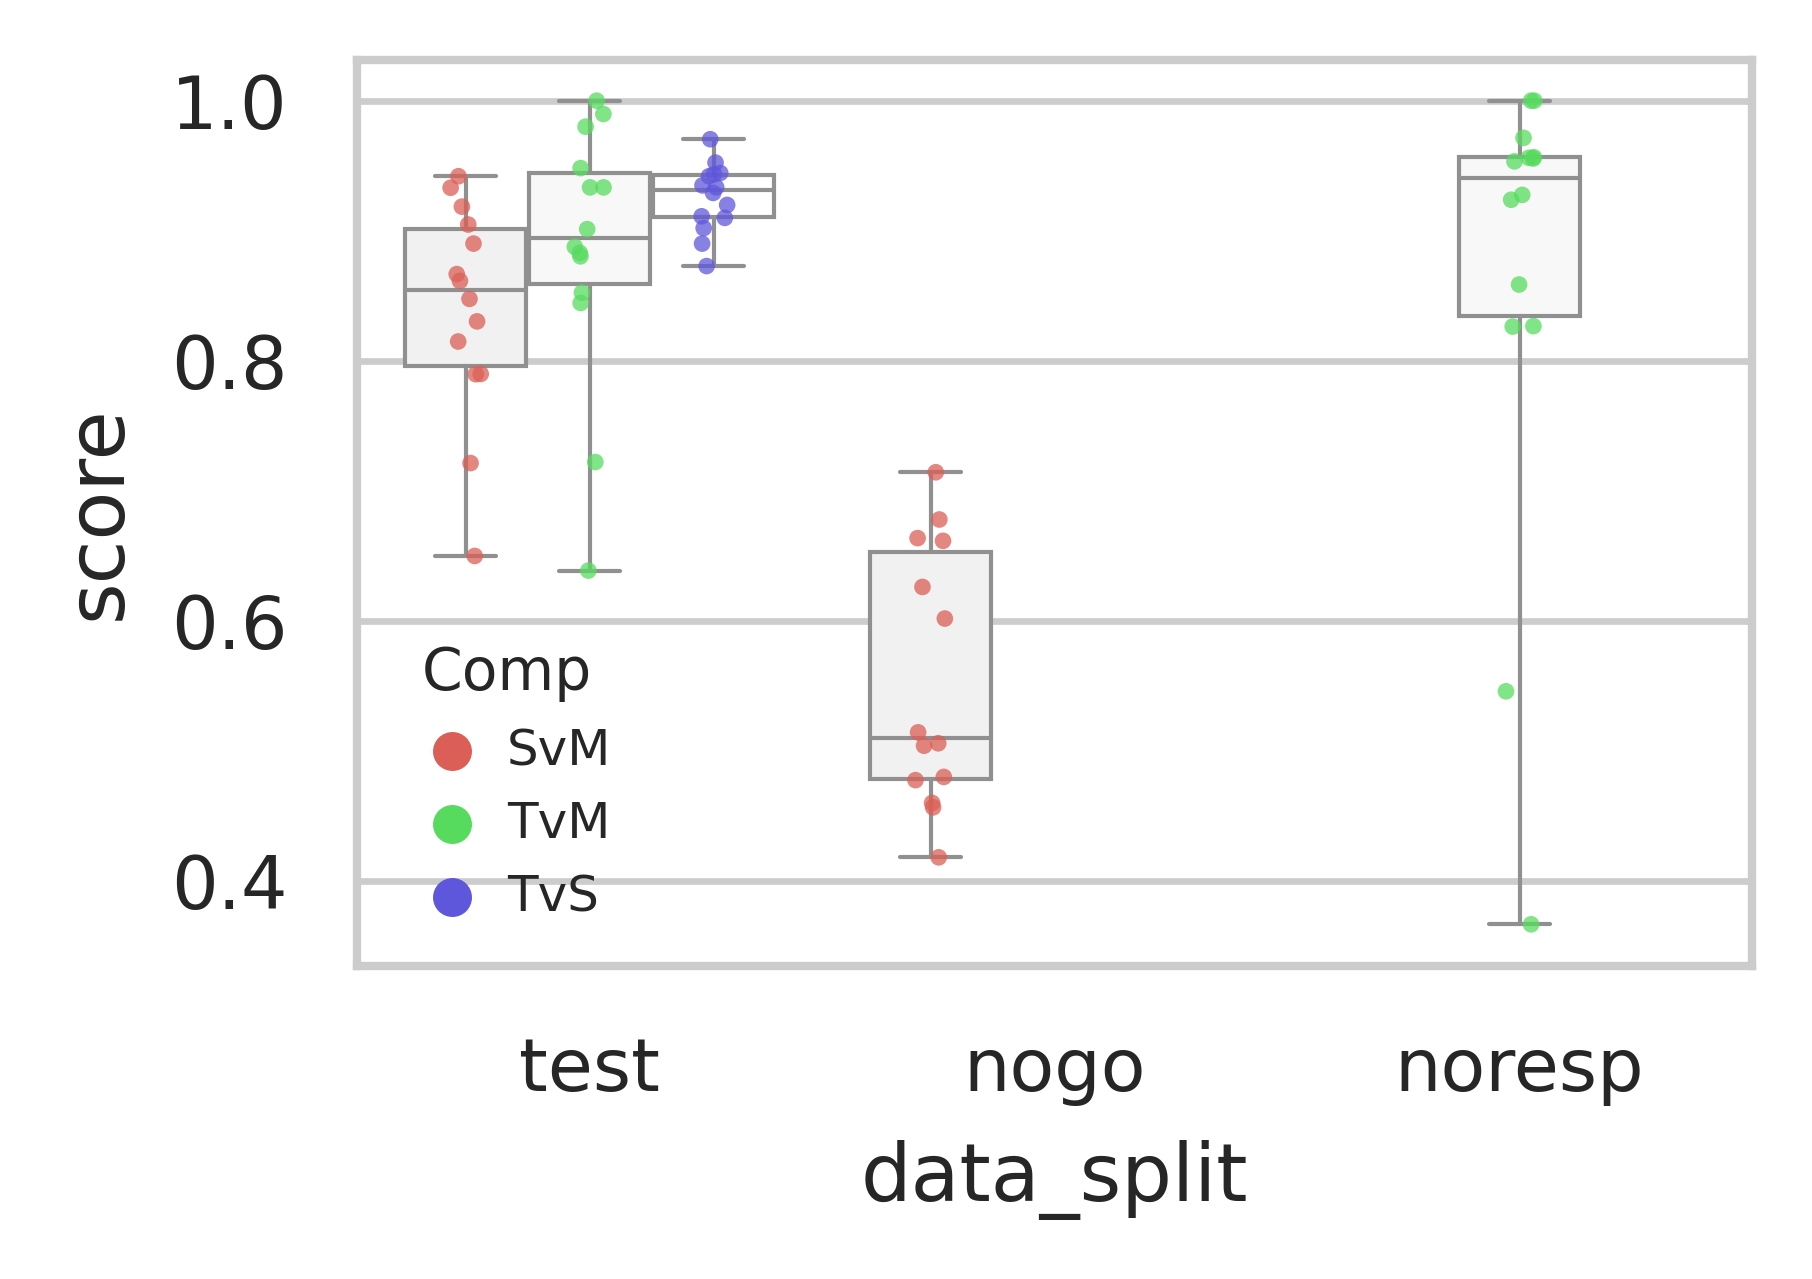

In [169]:
split_order = ['test', 'nogo', 'noresp']
hue_order = ['SvM', 'TvM', 'TvS']
time_bin=0
subset = perf_df_all[(perf_df_all.pert_matrix=='A1') & (perf_df_all.pert_pct==0) & (perf_df_all.data_split.isin(split_order)) &  (perf_df_all.time_bin==time_bin)]
subset = subset.groupby(["session_num", "comparison", "data_split"], dropna=True).mean()
#subset = subset.drop(['time_bin', 'pert_pct'],axis=1)
subset = subset.drop(['pert_pct'],axis=1)
subset = subset.reset_index()
subset = subset.copy()
subset.loc[ (subset.data_split=='nogo') & (subset.comparison.isin(['TvM', 'TvS'])) ] = np.nan
subset.loc[ (subset.data_split=='noresp') & (subset.comparison.isin(['SvM', 'TvS'])) ] = np.nan
subset = subset.dropna()


sns.set_theme(context='paper', style="whitegrid", font_scale=1)
sns.set_palette("hls",n_colors=3)
f,ax=plt.subplots(figsize=(3,2), dpi=600)

sns.boxplot(x='data_split', y='score',hue='comparison',data=subset,whis=100, ax=ax, color='w', order=split_order, hue_order=hue_order, linewidth=0.5)
sns.stripplot(x='data_split', y='score',hue='comparison',data=subset, dodge=True, alpha=0.75,size=2, order=split_order,ax=ax)

h,l = ax.get_legend_handles_labels()
ax.legend(h[3:],l[3:],title='Comp', bbox_to_anchor=(0, 0), handletextpad=0.1, loc='lower left', frameon=False, fontsize=6, title_fontsize=7, markerscale=0.5)

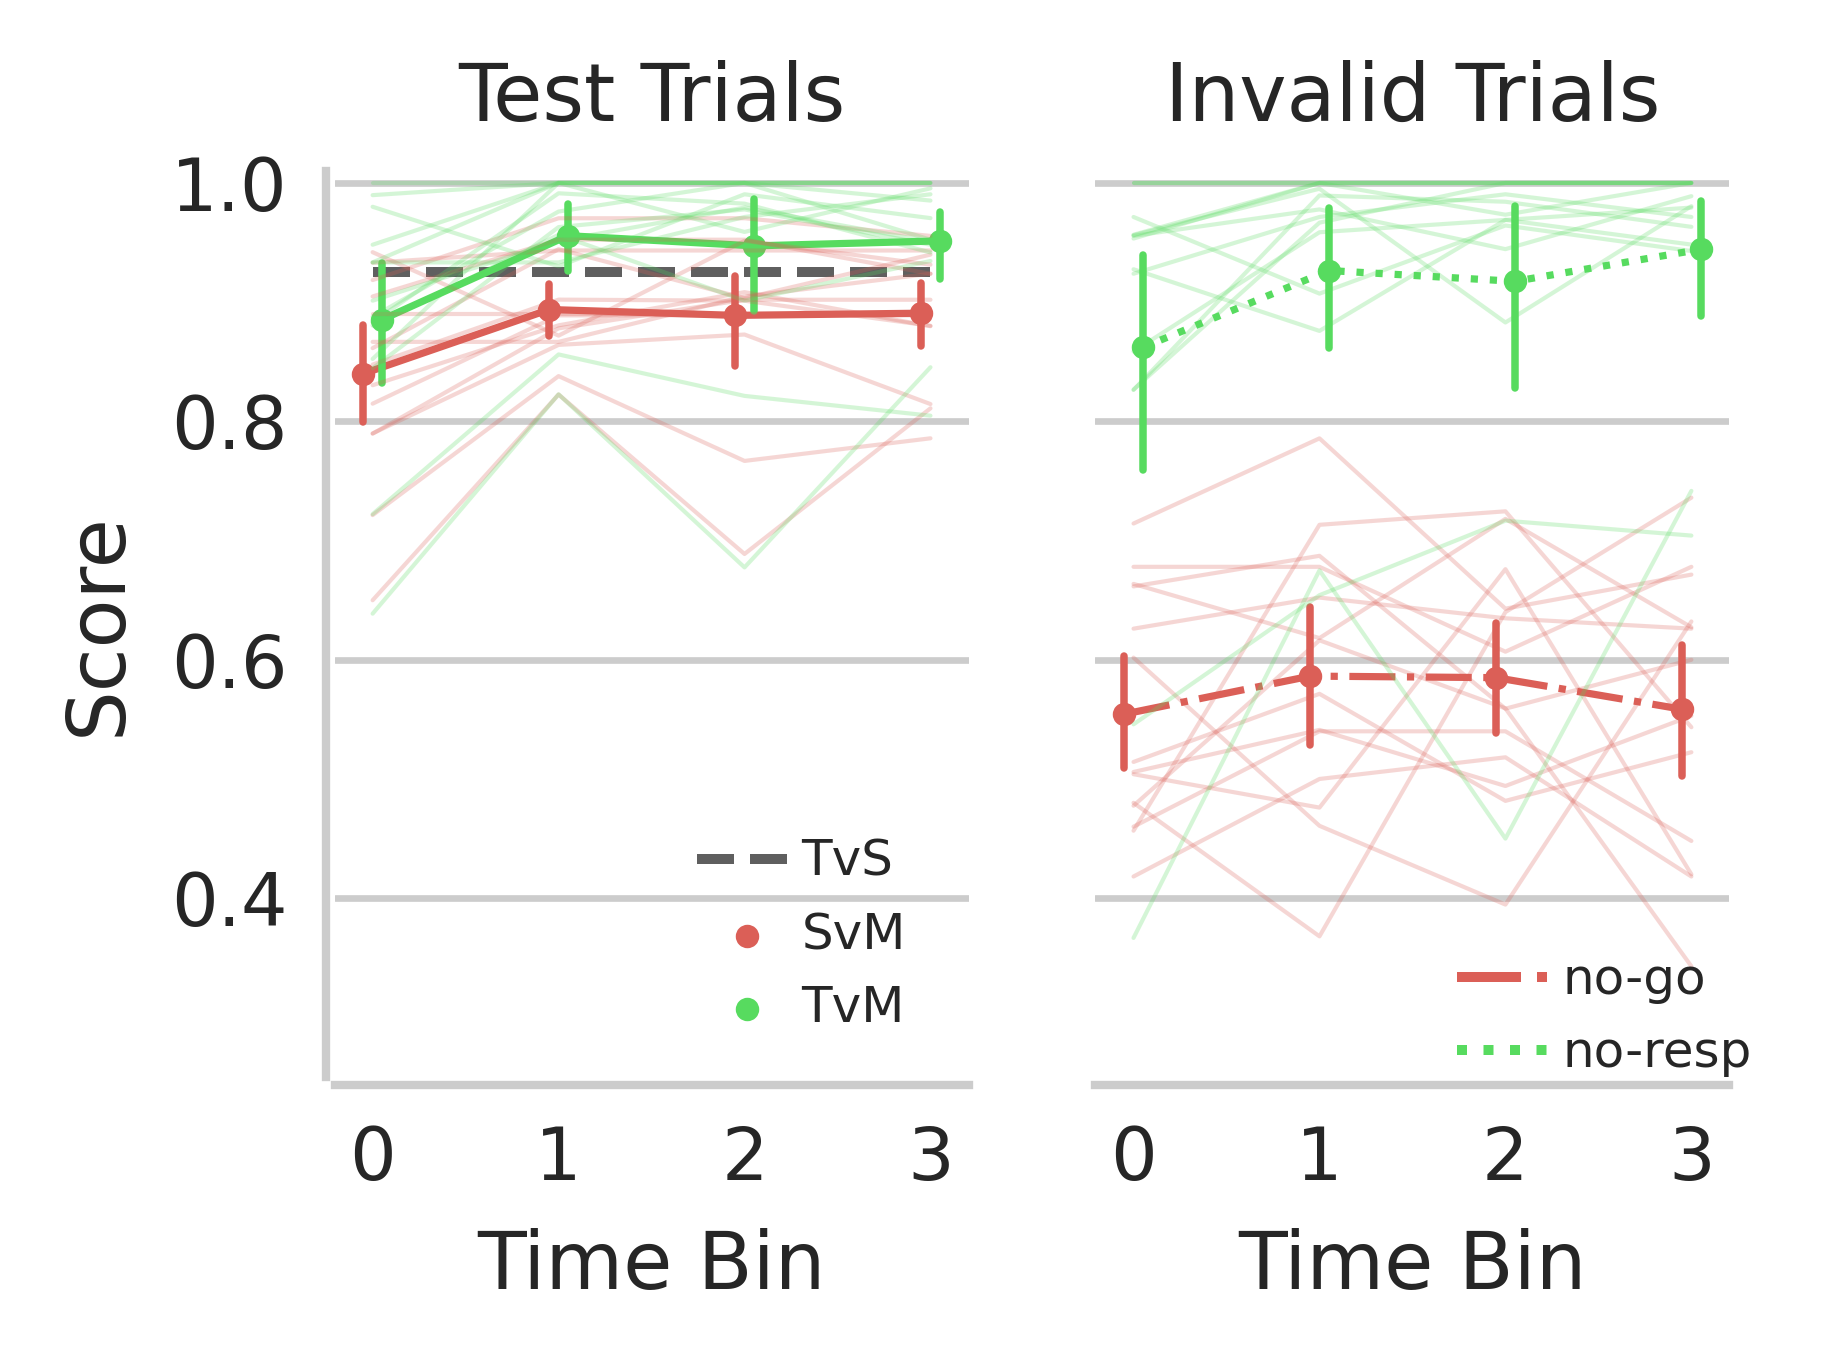

In [218]:



sns.set_theme(context='paper', style="whitegrid", font_scale=1)
sns.set_palette("hls",n_colors=3)

f,axes=plt.subplots(1,2, figsize=(3,2), dpi=600)
ax=axes[0]


split_order = ['test']
comparison_select = ['SvM', 'TvM']

subset = perf_df_all[(perf_df_all.pert_matrix=='A1') & (perf_df_all.pert_pct==0) & (perf_df_all.data_split.isin(split_order)) & (perf_df_all.comparison.isin(comparison_select))]
subset = subset.groupby(["session_num", "comparison", "data_split", "time_bin"], dropna=True).mean()
subset = subset.drop(['pert_pct'],axis=1)
subset = subset.reset_index()
subset = subset.copy()
subset.loc[ (subset.data_split=='nogo') & (subset.comparison.isin(['TvM', 'TvS'])) ] = np.nan
subset.loc[ (subset.data_split=='noresp') & (subset.comparison.isin(['SvM', 'TvS'])) ] = np.nan
subset = subset.dropna()

sns.pointplot(x='time_bin', y='score', hue='comparison',  data=subset, err_style='bars', ax=ax, dodge=0.1, alpha=1, legend=False, scale=0.4, errwidth=0.9)
sns.lineplot(x='time_bin', y='score', hue='comparison', units='session_num', estimator=None, data=subset, alpha=0.25, ax=ax, legend=False, linewidth=0.5)

split_order = ['test']
comparison_select = ['TvS']
subset = perf_df_all[(perf_df_all.pert_matrix=='A1') & (perf_df_all.pert_pct==0) & (perf_df_all.data_split.isin(split_order)) & (perf_df_all.comparison.isin(comparison_select))]

ax.plot(np.arange(4), [subset.groupby('session_num').mean()['score'].mean()]*4, color='0.3', alpha=0.9, linestyle='--', zorder=-1, label='TvS')
   
h,l = ax.get_legend_handles_labels()
ax.legend(h,l, bbox_to_anchor=(0.5, 0), handletextpad=0.1, loc='lower left', frameon=False, fontsize=6, title_fontsize=7, markerscale=1)

ax.set_ylim([0.25, 1.01])
ax.set_xticklabels(np.arange(4))
ax.set_xlabel("Time Bin")
ax.set_ylabel("Score")
ax.tick_params(axis='both', which='major', pad=-0.2)


ax.set_title("Test Trials")
##
ax = axes[1]

split_order = ['nogo', 'noresp']
comparison_select = ['SvM', 'TvM']

subset = perf_df_all[(perf_df_all.pert_matrix=='A1') & (perf_df_all.pert_pct==0) & (perf_df_all.data_split.isin(split_order)) & (perf_df_all.comparison.isin(comparison_select))]
subset = subset.groupby(["session_num", "comparison", "data_split", "time_bin"], dropna=True).mean()
subset = subset.drop(['pert_pct'],axis=1)
subset = subset.reset_index()
subset = subset.copy()
subset.loc[ (subset.data_split=='nogo') & (subset.comparison.isin(['TvM', 'TvS'])) ] = np.nan
subset.loc[ (subset.data_split=='noresp') & (subset.comparison.isin(['SvM', 'TvS'])) ] = np.nan
subset = subset.dropna()

dashes= ['-.',  ':']
sns.pointplot(x='time_bin', y='score', hue='data_split', linestyles=dashes, data=subset, err_style='bars', ax=ax, 
              dodge=0.1, alpha=1, legend=False, scale=0.4, errwidth=0.9)
sns.lineplot(x='time_bin', y='score', hue='data_split', dashes={'nogo':dashes[0], 'noresp' : dashes[1]}, 
             units='session_num', estimator=None, data=subset, alpha=0.25, ax=ax, legend=False, linewidth=0.5)

ax.set_ylim([0.25, 1.01])
ax.set_ylabel('')
ax.set_yticklabels('')

ax.set_xticklabels(np.arange(4))
ax.set_xlabel("Time Bin")

#ax.legend()

ax.tick_params(axis='both', which='major', pad=-0.2)
ax.get_legend().remove()


colors = sns.color_palette("hls",n_colors=3)

legend_elements = [Line2D([0], [0], color=colors[0], linestyle='-.', label='no-go'),
                   Line2D([0], [0], color=colors[1], linestyle=':', label='no-resp')]

ax.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.05), handletextpad=0.1, loc='lower left', frameon=False, fontsize=6, title_fontsize=7, markerscale=0.5)

sns.despine(offset=1, trim=False)
ax.spines['left'].set_visible(False)

ax.set_title("Invalid Trials")

f.savefig(f"time_data-splits_all.pdf",bbox_inches='tight')

In [208]:
sns.ge


<module 'seaborn.palettes' from '/home/alexgonzalez/anaconda3/envs/wombats/lib/python3.8/site-packages/seaborn/palettes.py'>

/home/alexgonzalez/anaconda3/envs/wombats/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/alexgonzalez/anaconda3/envs/wombats/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<AxesSubplot:>

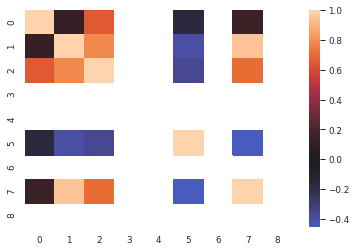

In [232]:
time_bin=1

set_comparisons = comparisons
set_data_splits = ['test', 'nogo', 'noresp']
subset = perf_df_all[(perf_df_all.pert_matrix=='A1') & (perf_df_all.pert_pct==0) & (perf_df_all.data_split.isin(set_data_splits)) & (perf_df_all.time_bin==time_bin)]

subset = subset.groupby(['comparison', "data_split", "session_num"]).mean()
subset = subset.reset_index()
#set_data_splits = ['train', 'nogo', 'noresp']



combinations = np.zeros((n_sessions, len(set_data_splits)*len(set_comparisons)))
cnt=0
for split in set_data_splits:
    for comp in set_comparisons: 
        combinations[:,cnt] = subset.loc[(subset.comparison==comp) & (subset.data_split==split), 'score'].values
        cnt+=1

sns.heatmap(np.corrcoef(combinations.T), center=0)

<AxesSubplot:>

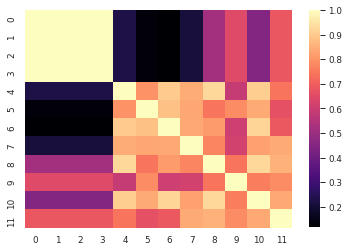

In [241]:
set_comparisons = comparisons
set_data_splits = ['test']
set_time_bins = list(time_windows.keys())

subset = perf_df_all[(perf_df_all.pert_matrix=='A1') & (perf_df_all.pert_pct==0) & (perf_df_all.data_split.isin(set_data_splits))]

subset = subset.groupby(['comparison', "data_split", "session_num", "time_bin"]).mean()
subset = subset.reset_index()

combinations = np.zeros((n_sessions, len(set_time_bins)*len(set_comparisons)))
cnt=0

for comp in set_comparisons: 
    for time_bin in set_time_bins:
        combinations[:,cnt] = subset.loc[(subset.comparison==comp) & (subset.time_bin==time_bin), 'score'].values
        cnt+=1

sns.heatmap(np.corrcoef(combinations.T), cmap='magma')

<AxesSubplot:>

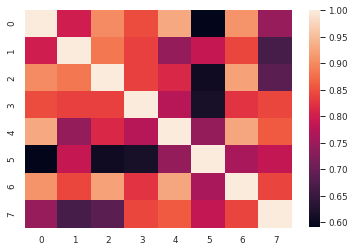

In [248]:
CC = np.corrcoef(combinations.T)
sns.heatmap(CC[4:,4:])

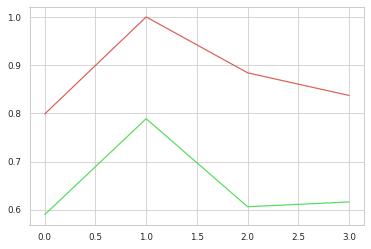

In [254]:
plt.plot(CC[4:8,5])
plt.plot(CC[4:8,9])

(113, 214, 1)